This file contains the Data collection and Baseline Model code

#**Part 1. Loading the dataset**

In [ ]:
# Importing modules
import librosa as librosa
import librosa.display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os, random, cv2
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torchaudio
import torch.nn.functional as F
import torch.optim as optim
import shutil
import cv2
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from IPython.display import Audio
import skimage.io

In [ ]:
# To install Kaggle
!pip install -q kaggle

Steps
- Download the kaggle.json file from the project drive before running this section.
- After downloading, run the next block and select choose file, then upload the kaggle.json file

In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"oluwasina23","key":"2fff39c0d5a5ab5e20a7bec41c26a57d"}'}

In [ ]:
#create a kaggle folder
! mkdir ~/.kaggle

In [ ]:
#copy kaggle.json to folder created
! cp kaggle.json ~/.kaggle/

In [ ]:
#json permission
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d oluwasina23/gtzan-data

100% 1.21G/1.21G [00:43<00:00, 35.3MB/s]
100% 1.21G/1.21G [00:44<00:00, 29.6MB/s]


In [ ]:
!unzip gtzan-data.zip

Archive:  gtzan-data.zip
  inflating: Data/features_30_sec.csv  
  inflating: Data/features_3_sec.csv  
  inflating: Data/genres_original/blues/blues.00000.wav  
  inflating: Data/genres_original/blues/blues.00001.wav  
  inflating: Data/genres_original/blues/blues.00002.wav  
  inflating: Data/genres_original/blues/blues.00003.wav  
  inflating: Data/genres_original/blues/blues.00004.wav  
  inflating: Data/genres_original/blues/blues.00005.wav  
  inflating: Data/genres_original/blues/blues.00006.wav  
  inflating: Data/genres_original/blues/blues.00007.wav  
  inflating: Data/genres_original/blues/blues.00008.wav  
  inflating: Data/genres_original/blues/blues.00009.wav  
  inflating: Data/genres_original/blues/blues.00010.wav  
  inflating: Data/genres_original/blues/blues.00011.wav  
  inflating: Data/genres_original/blues/blues.00012.wav  
  inflating: Data/genres_original/blues/blues.00013.wav  
  inflating: Data/genres_original/blues/blues.00014.wav  
  inflating: Data/genres_o

In [ ]:
#Delete zip file after unzipping
! rm gtzan-data.zip

# Part 2. **Converting each split into a spectrogram set and storing it**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# set the master path and generate the classlist

Mpath = "/content/drive/MyDrive/Project/WavData"
classes = [i for i in os.listdir(Mpath)]
type(classes[0]) #ensure the list is appropriate type --> str

str

In [ ]:
#make the parent processed data directory
os.mkdir("/content/New_Spec_Data")


In [ ]:
# create dataset folders
os.mkdir("/content/Processed_Data/valid")
os.mkdir("/content/Processed_Data/train")
os.mkdir("/content/Processed_Data/test")

In [ ]:
# function to convet the .wav files to spectrograms
def convert_to_spectrogram(wav_file, path):
  y, sr = librosa.load(wav_file, sr =32000)
  n_fft = 1024
  hop_length = 320
  window_type = 'hann'
  spectrogram_librosa = np.abs(librosa.stft(y, n_fft=n_fft,
                                            hop_length=hop_length,
                                            win_length=n_fft,
                                            window=window_type)) **2

  mel_bins = 64 # Number of mel bands
  fmin = 0
  fmax= None
  Mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft,
                                                  hop_length=hop_length,
                                                  win_length=n_fft,
                                                  window=window_type,
                                                  n_mels = mel_bins,
                                                  power=2.0)

  mel_spectrogram_db = librosa.power_to_db(Mel_spectrogram, ref=np.max)

  fig = plt.Figure(figsize=(8,8), dpi=128, frameon=False)
  canvas = FigureCanvas(fig)
  ax = fig.add_subplot(111)
  ax.axes.get_xaxis().set_visible(False)
  ax.axes.get_yaxis().set_visible(False)
  ax.set_frame_on(False)
  librosa.display.specshow(mel_spectrogram_db)
  fig1 = plt.gcf()
  plt.show() #need to visualize before saving
  plt.draw()
  fig1.savefig(path+'.png', dpi= 128, bbox_inches='tight') #save as png
  print('done')
###############
#   This function is very inefficient in terms of space and time use.
#   it should not be ran more than once, if not it will
#   deplete storage available.

In [ ]:
os.mkdir('/content/New_Spec_Data/Spectrograms/')
for i in classes:
  os.mkdir(os.path.join('/content/New_Spec_Data/Spectrograms/',i))

In [ ]:
import cv2

In [ ]:
from numpy.linalg import test
test_img = '/content/drive/MyDrive/Project/Processed_Data/test/blues/22.png'
im = cv2.imread(test_img)
print(im.shape)

(418, 627, 3)


In [ ]:
E_log = []
for i in classes:
  count = 300
  if i == '.DS_Store':
    continue
  for j in os.listdir(os.path.join(Mpath, i)):
    print(j)
    try:
      convert_to_spectrogram(os.path.join(Mpath, i, j), os.path.join('/content/New_Spec_Data/Spectrograms', i, str(count)))
    except Exception as e:
      E_log.append(e)
      continue
    count+=1

In [ ]:
len(E_log) #check how much of the data threw an error

1

NOTES:
- the dataset comes with some spectrograms already.
- after initial tests have been conducted, if we need to improve the model accuracy
  - we can augment the current data
  - we can add in the original data and augment that as well
  
  Augmentations could be:
  - image rotation
  - blurring
  - adding noise
- Look into using encodings for better representation of features

#Part 3. **Splitting the dataset**

In [ ]:
# Defining paths and destinations

specPath = '/content/New_Spec_Data/Spectrograms'
train_set = '/content/New_Spec_Data/Split_Set/train'
val_set = '/content/New_Spec_Data/Split_Set/valid'
test_set = '/content/New_Spec_Data/Split_Set/test'

In [ ]:
pths = [train_set, test_set, val_set]
# Using shutil to copy the files and stipulating the conditions for moving
for p in pths:
  for i in classes:
    if i == '.DS_Store':
      continue
    os.mkdir(os.path.join(p, i))

In [ ]:
count = 0
for i in classes:
  for j in os.listdir(os.path.join(specPath, i)):
    if count <= len(os.listdir(os.path.join(specPath, i)))*0.6: #60% of the data goes to training
      shutil.copy(os.path.join(specPath, i, j), os.path.join(train_set, i))
    elif (count >= len(os.listdir(os.path.join(specPath, i)))*0.6
          and count <= len(os.listdir(os.path.join(specPath, i)))*0.8): #20% goes to testing
      shutil.copy(os.path.join(specPath, i, j), os.path.join(test_set, i))
    else:
      shutil.copy(os.path.join(specPath, i, j), os.path.join(val_set, i))#20% goes to validation
    count += 1
  count = 0


In [ ]:
for i in os.listdir(train_set):
  for j in os.listdir(os.path.join(train_set, i)):
    shutil.copy(os.path.join(train_set, i, j), os.path.join('/content/drive/MyDrive/Project/NewData_spotify/Split_Set/train', i))
for i in os.listdir(train_set):
  for j in os.listdir(os.path.join(val_set, i)):
    shutil.copy(os.path.join(val_set, i, j), os.path.join('/content/drive/MyDrive/Project/NewData_spotify/Split_Set/valid', i))
for i in os.listdir(test_set):
  for j in os.listdir(os.path.join(test_set, i)):
    shutil.copy(os.path.join(test_set, i, j), os.path.join('/content/drive/MyDrive/Project/NewData_spotify/Split_Set/test', i))



In [ ]:
for i in os.listdir('/content/drive/MyDrive/Project/NewData_spotify/Split_Set/train'):
  print(i)
  print(len(os.listdir(os.path.join('/content/drive/MyDrive/Project/NewData_spotify/Split_Set/train', i))))
for i in os.listdir('/content/drive/MyDrive/Project/NewData_spotify/Split_Set/test'):
  print(i)
  print(len(os.listdir(os.path.join('/content/drive/MyDrive/Project/NewData_spotify/Split_Set/test', i))))
for i in os.listdir('/content/drive/MyDrive/Project/NewData_spotify/Split_Set/valid'):
  print(i)
  print(len(os.listdir(os.path.join('/content/drive/MyDrive/Project/NewData_spotify/Split_Set/valid', i))))



reggae
181
country
181
blues
181
classical
181
rock
181
disco
181
metal
181
jazz
181
.ipynb_checkpoints
0
hip-hop
181
pop
181
300


#Part 4. **Converting the data to tensors of appropriate shape. The images are 432x288**

Because this is so robust and time consuming to run, I will be saving the already processed data to the drive, rather than loading it again everytime the session is disconnected.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
drive_path='/content/drive/MyDrive/Project/Processed_Data'
os.mkdir(drive_path)
os.mkdir(drive_path+'/'+'valid')
os.mkdir(drive_path+'/'+'test')
os.mkdir(drive_path+'/'+'train')


In [ ]:
# moving the files to the drive
shutil.move('/content/Processed_Data/test', drive_path+'/')
shutil.move('/content/Processed_Data/train', drive_path+'/')
shutil.move('/content/Processed_Data/valid', drive_path+'/')

'/content/drive/MyDrive/Project/Processed_Data/valid'

In [ ]:
#overwritting the previous data set variables
drive_path='/content/drive/MyDrive/Project/Processed_Data'
train_set = drive_path+'/'+'train'
val_set = drive_path+'/'+'valid'
test_set = drive_path+'/'+'test'

In [ ]:
#Defining transforms
transform = transforms.Compose([transforms.Resize((418,627)),
                                transforms.ToTensor()])

In [ ]:
train_dataset = torchvision.datasets.ImageFolder(train_set +'/', transform=transform)
valid_dataset = torchvision.datasets.ImageFolder(val_set+'/', transform=transform)
test_dataset = torchvision.datasets.ImageFolder(test_set+'/', transform=transform)

print("train set size: ", len(train_dataset))
print("validation set size: ", len(valid_dataset))
print("test set size: ", len(test_dataset))

train set size:  609
validation set size:  190
test set size:  200


In [ ]:
# shuffle moved data
batch_size = 128
num_workers = 1

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                           num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size,
                                           num_workers=num_workers, shuffle=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           num_workers=num_workers, shuffle=True)

# Verification Step - obtain one batch of features
dataiter = iter(train_loader)
features, labels = next(dataiter)
print(features.shape)
print(labels.shape)

torch.Size([128, 3, 418, 627])
torch.Size([128])


# Part 5. Baseline Model (KNN)
The following code contains the functions necessary for computing the accuracy of our chosen baseline model. The set space is populated by the entire collection of training data. Each image in the test set is compared to the set space and its distance from all points in the set space is calculated. The distances are sorted from lowest to highest, and the neighbours are set as first k closest distance points. The class that is most commonly appears in the set of neighbours is the predicted class.

In order to carry out the calculations, the images needed to be transformed into flattened one-dimensional vectors.

In [ ]:
def process_images(train_path, test_path):

    # Need to flatten the images into vectors
    transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: torch.flatten(x))])

    train = torchvision.datasets.ImageFolder(train_path + '/', transform)
    test = torchvision.datasets.ImageFolder(test_path + '/', transform)

    print("train set size: ", len(train))

    print("Getting training images")
    # Collect the tensors representing the flattened images and their respective labels
    Xt, Lt = [], []
    for images, labels in train:
        # Get image data (train)
        Xt.append(images)
        # Get label data (train)
        Lt.append(labels)
    # Reformat train images
    Xt = torch.stack(Xt)

    # Collect the tensors representing the flattened images and their respective labels

    # Shuffle the order
    numInd = len(test)
    shuff = list(range(numInd))
    np.random.shuffle(shuff)

    print("Getting testing images")
    Xe, Le = [], []
    for i in shuff:
        images, labels = test[i]
        # Get image data (test)
        Xe.append(images)
        # Get label data (test)
        Le.append(labels)
    # Reformat test images
    Xe = torch.stack(Xe)

    return Xt, Lt, Xe, Le

In [ ]:
# Calculate distance between vectors
def calc_distances(Xt, vec):
    # Xt is the set of training points
    # Vec is the new vector point

    distances = []

    # Euclidian distance
    for i in range(len(Xt)):
        distance = np.linalg.norm(Xt[i]-vec)
        distances.append(distance)

    return distances

In [ ]:
# Calculate the locations of each class within the set space
def get_nearest_neighbours(Xt, Lt, vec, k):
    # Xt: training set image vectors
    # Lt: training set label vectors
    # vec: instance vector
    # k: the number of neighbours to save

    dist_vals = []
    distances = calc_distances(Xt, vec) # get the distance between every point in training set and test instance
    for m in range(len(distances)):
        dist_vals.append((distances[m], Lt[m])) # Create tuple to keep track of label

     # sort the values by distance from smallest to largest (sort by distance)
    sorted_dist = sorted(dist_vals, key=lambda x: x[0])

    # get k nearest neighbours
    # Contains neighbour neighbour [distance, class]
    neighbours = []
    for i in range (0, k):
        neighbours.append(sorted_dist[i])

    return neighbours

In [ ]:
# Get the class of the new input vector
def get_class(neighbours):
    # Neighbours is a list of tuples containing distance (float), class (vector)

    appearClass = {}
    # Get dictionary of appearing classes
    for i in range(len(neighbours)):
        getIndex = (neighbours[i][1])
        appearClass[getIndex] = appearClass.get(getIndex, 0) + 1

    ### If the highest frequency is 1 for all neighbours - closest distance is class

    # Check max frequency
    max_freq = max(appearClass.values())

    if max_freq == 1:
        predicted_class = neighbours[0][1]
    else:
        # Get the index of the most frequently appearing class
        predicted_class = max(appearClass, key=appearClass.get)

    return predicted_class

In [ ]:
def predict(Xt, Lt, Xe, k):
    # Parameters - training image vectors, train labels, and test image vectors
    classes = []


    for image in Xe:
        im_class = get_class(get_nearest_neighbours(Xt, Lt, image, k))
        #print("Image " + str(count+1) + " predicted!")
        classes.append(im_class)

    return classes

In [ ]:
def predict_n(Xt, Lt, Xe, k, n):
        # Parameters - training image vectors, train labels, and test image vectors
    classes = []


    for image in Xe:
        im_class = get_n_classes(get_nearest_neighbours(Xt, Lt, image, k), n)
        #print("Image " + str(count+1) + " predicted!")
        classes.append(im_class)

    return classes

In [ ]:
def get_n_classes(neighbours, n):
        # Neighbours is a list of tuples containing distance (float), class (vector)

    appearClass = {}
    # Get dictionary of appearing classes
    for i in range(len(neighbours)):
        getIndex = (neighbours[i][1])
        appearClass[getIndex] = appearClass.get(getIndex, 0) + 1

    ### If the highest frequency is 1 for all neighbours - closest distance is class

    # Check max frequency
    max_freq = max(appearClass.values())

    if max_freq == 1:
        predicted_class = neighbours[0:n][1]
    else:
        # Get the index of the most frequently appearing class
        sortedDict = sorted(appearClass.items(), key=lambda x:x[1],reverse=True)
        #print(sortedDict)
        predicted_class = []
        if len(sortedDict) < n:
            for k in range(len(sortedDict)):
                predicted_class.append(sortedDict[k][0])
        else:
            for j in range(n):
                predicted_class.append(sortedDict[j][0])
        #print(predicted_class)

    return predicted_class

In [ ]:
def KNN_accuracy(Xt, Lt, Xe, Le, k):

    predictions = predict(Xt, Lt, Xe, k)

    get_true_numerical = Le
    get_pred_numerical = np.array(predictions)

    category_accuracies = [0]*10
    category_totals = [0]*10
    category_accuracy = []
    accuracy = 0
    for j in range(len(get_true_numerical)):
        category_totals[get_true_numerical[j]] += 1
        if get_true_numerical[j] == get_pred_numerical[j]:
            accuracy += 1
            category_accuracies[get_true_numerical[j]] += 1

    accuracy = accuracy/len(get_pred_numerical)

    for k in range(10):
        category_accuracy.append(category_accuracies[k]/category_totals[k])

    return accuracy, category_accuracy, category_totals

In [ ]:
def KNN_2_accuracy(Xt, Lt, Xe, Le, k, n):

    predictions = predict_n(Xt, Lt, Xe, k, n)

    get_true_numerical = Le
    get_pred_numerical = np.array(predictions)

    category_accuracies = [0]*10
    category_totals = [0]*10
    category_accuracy = []
    accuracy = 0
    for j in range(len(get_true_numerical)):
        print(get_true_numerical[j], get_pred_numerical[j])
        if get_true_numerical[j] in get_pred_numerical[j]:
            accuracy += 1

    accuracy = accuracy/len(get_pred_numerical)

    #print(accuracy, len(get_pred_numerical))

    return accuracy

In [ ]:
# Get the data loaded (flattened vectors)
Xt, Lt, Xe, Le = process_images(train_set, test_set)


In [ ]:
accuracy, category_accuracy, category_totals = KNN_accuracy(Xt, Lt, Xe, Le, 25)
print("The accuracy of the KNN baseline model (where k = 25) is ", accuracy)

The accuracy of the KNN baseline model (where k = 25) is  0.375


[20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
[0.15, 0.6, 0.4, 0.05, 0.6, 0.3, 1.0, 0.65, 0.0, 0.0]


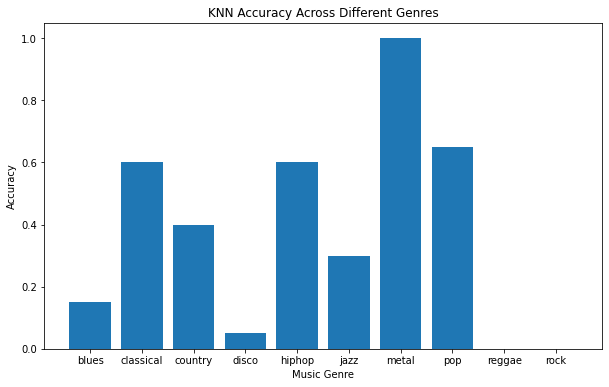

In [ ]:
categories = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

print(category_totals)
print(category_accuracy)

plt.figure(figsize=(10,6))
plt.bar(categories, category_accuracy)
plt.xlabel("Music Genre")
plt.ylabel("Accuracy")
plt.title("KNN Accuracy Across Different Genres")
plt.show()

Following Tests use new data from Spotify

In [ ]:
#overwritting the previous data set variables
drive_path='/content/drive/MyDrive/Project/NewData_spotify/Split_Set'
train_set = drive_path+'/'+'train'
val_set = drive_path+'/'+'valid'
test_set = drive_path+'/'+'test'


# Get the data loaded (flattened vectors)
Xt, Lt, Xe, Le = process_images(train_set, test_set)

train set size:  3020
Getting training images
Getting testing images


In [ ]:
accuracy, category_accuracy, category_totals = KNN_accuracy(Xt, Lt, Xe, Le, 25)
print("The accuracy of the KNN baseline model (where k = 25) is ", accuracy)

The accuracy of the KNN baseline model (where k = 25) is  0.327


[100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
[0.13, 0.93, 0.37, 0.03, 0.09, 0.78, 0.71, 0.06, 0.0, 0.17]


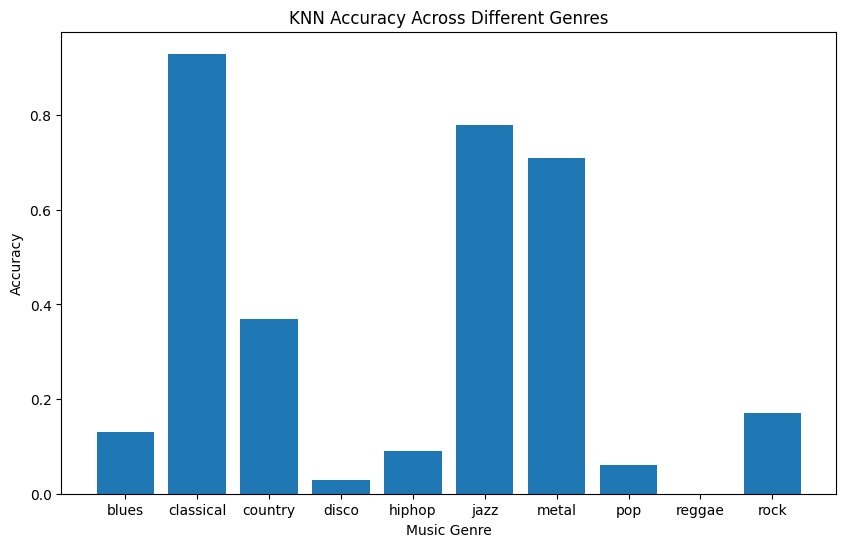

In [ ]:
categories = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

print(category_totals)
print(category_accuracy)

plt.figure(figsize=(10,6))
plt.bar(categories, category_accuracy)
plt.xlabel("Music Genre")
plt.ylabel("Accuracy")
plt.title("KNN Accuracy Across Different Genres")
plt.show()

In [ ]:
accuracy, category_accuracy, category_totals = KNN_accuracy(Xt, Lt, Xe, Le, 55)
print("The accuracy of the KNN baseline model (where k = 55) is ", accuracy)

The accuracy of the KNN baseline model (where k = 55) is  0.318


[100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
[0.11, 0.89, 0.37, 0.07, 0.14, 0.78, 0.74, 0.01, 0.0, 0.07]


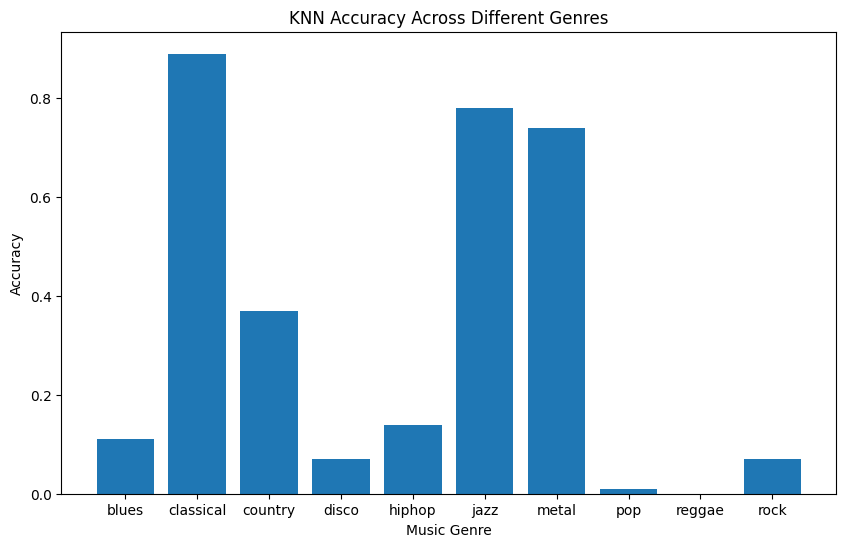

In [ ]:
categories = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

print(category_totals)
print(category_accuracy)

plt.figure(figsize=(10,6))
plt.bar(categories, category_accuracy)
plt.xlabel("Music Genre")
plt.ylabel("Accuracy")
plt.title("KNN Accuracy Across Different Genres")
plt.show()

The following tests are based on the Youtube data collected

In [ ]:
#overwritting the previous data set variables
drive_path='/content/drive/MyDrive/Project/NewData_spotify/Split_Set'
new_path = '/content/drive/MyDrive/Project/NewData_YT/Spectrograms'
train_set = drive_path+'/'+'train'
test_set = new_path


# Get the data loaded (flattened vectors)
Xt, Lt, Xe, Le = process_images(train_set, test_set)

train set size:  3020
Getting training images
Getting testing images


In [ ]:
# Top 1 accuracy
accuracy, category_accuracy, category_totals = KNN_accuracy(Xt, Lt, Xe, Le, 55)
print("The accuracy of the KNN baseline model (where k = 55) is ", accuracy)

The accuracy of the KNN baseline model (where k = 55) is  0.15


In [ ]:
# Top 2 accuracy
accuracy = KNN_2_accuracy(Xt, Lt, Xe, Le, 55, 2)
print("The accuracy of the KNN baseline model (top 2 predictions) (where k = 55) is ", accuracy)

8 [5]
5 [2, 0]
3 [2, 6]
5 [5, 0]
8 [3, 2]
3 [5, 4]
7 [5]
9 [2, 7]
7 [2, 0]
4 [5, 1]
9 [6, 9]
1 [1, 0]
0 [5, 0]
4 [2, 3]
2 [3, 4]
1 [5, 7]
0 [1, 0]
2 [2, 7]
6 [2, 7]
6 [9, 2]
The accuracy of the KNN baseline model (top 2 predictions) (where k = 55) is  0.3


<ipython-input-67-c2d9d5970624>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  get_pred_numerical = np.array(predictions)


In [ ]:
# Top 3
accuracy3 = KNN_2_accuracy(Xt, Lt, Xe, Le, 55, 3)
print("The accuracy of the KNN baseline model (top 3 predictions) (where k = 55) is ", accuracy3)

8 [5]
5 [2, 0, 3]
3 [2, 6, 9]
5 [5, 0, 3]
8 [3, 2, 7]
3 [5, 4, 3]
7 [5]
9 [2, 7, 5]
7 [2, 0, 9]
4 [5, 1]
9 [6, 9, 2]
1 [1, 0, 5]
0 [5, 0]
4 [2, 3, 7]
2 [3, 4, 6]
1 [5, 7, 4]
0 [1, 0, 5]
2 [2, 7, 0]
6 [2, 7, 6]
6 [9, 2, 6]
The accuracy of the KNN baseline model (top 3 predictions) (where k = 55) is  0.45


<ipython-input-67-c2d9d5970624>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  get_pred_numerical = np.array(predictions)


The following tests are based on the unique spotify data collected

In [ ]:
#overwritting the previous data set variables
drive_path='/content/drive/MyDrive/Project/NewData_spotify/Split_Set'
new_path = '/content/drive/MyDrive/Project/final_spectrograms'
train_set = drive_path+'/'+'train'
test_set = new_path


# Get the data loaded (flattened vectors)
Xt, Lt, Xe, Le = process_images(train_set, test_set)

train set size:  3020
Getting training images
Getting testing images


In [ ]:
accuracy, category_accuracy, category_totals = KNN_accuracy(Xt, Lt, Xe, Le, 55)
print("The accuracy of the KNN baseline model (where k = 55) is ", accuracy)

The accuracy of the KNN baseline model (where k = 55) is  0.35


In [ ]:
# Top 2
accuracy2 = KNN_2_accuracy(Xt, Lt, Xe, Le, 55, 2)
print("The accuracy of the KNN baseline model (top 2 predictions) (where k = 55) is ", accuracy2)

4 [6, 9]
9 [6, 2]
6 [6, 9]
6 [6, 9]
5 [5, 2]
3 [6, 9]
7 [5, 0]
8 [2, 3]
1 [1, 3]
2 [2, 6]
3 [4, 2]
8 [4, 5]
0 [5, 6]
7 [5, 1]
4 [5]
1 [1, 3]
2 [6, 2]
0 [4, 3]
9 [6, 9]
5 [5, 1]
The accuracy of the KNN baseline model (top 2 predictions) (where k = 55) is  0.45


<ipython-input-10-c2d9d5970624>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  get_pred_numerical = np.array(predictions)


In [ ]:
# Top 3
accuracy3 = KNN_2_accuracy(Xt, Lt, Xe, Le, 55, 3)
print("The accuracy of the KNN baseline model (top 3 predictions) (where k = 55) is ", accuracy3)

4 [6, 9, 2]
9 [6, 2, 9]
6 [6, 9, 2]
6 [6, 9, 0]
5 [5, 2, 6]
3 [6, 9, 2]
7 [5, 0]
8 [2, 3, 4]
1 [1, 3, 5]
2 [2, 6, 9]
3 [4, 2, 3]
8 [4, 5, 2]
0 [5, 6, 2]
7 [5, 1, 7]
4 [5]
1 [1, 3, 5]
2 [6, 2, 9]
0 [4, 3, 2]
9 [6, 9, 2]
5 [5, 1, 4]
The accuracy of the KNN baseline model (top 3 predictions) (where k = 55) is  0.6


<ipython-input-10-c2d9d5970624>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  get_pred_numerical = np.array(predictions)


# Part 6. Baseline Model (ANN)

Due to the poor performance of the KNN model, the team decided to create an ANN baseline model to better compare the CNN model performance to.

In [ ]:
## Create basline ANN
class Baseline(nn.Module):
    def __init__(self):
        super(Baseline, self).__init__()
        self.layer1 = nn.Linear(3*418*627, 300) # need input size of image
        self.layer2 = nn.Linear(300, 10)

    def forward(self, x):
        flattened = x.view(-1, 3*418*627) # -1, input from layer 1
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)

        return activation2



In [ ]:
use_cuda = True
def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    for imgs, labels in data_loader:

        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()


        output = model(imgs)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
def get_genre_accuracy(model, data_loader):
    correct = [0]*10
    total = [0]*10
    acc = []

    genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

    for images, labels in iter(data_loader):
        for index, image in enumerate(images):
            images, labels = images.cuda(), labels.cuda()
            output = model(images)
            probs = nn.Softmax(dim=1)
            output = probs(output)

            predclass = torch.argmax(output)
            total[labels] += 1

            if predclass == labels:
                correct[predclass] += 1

    for i in range(0,10):
        acc.append(correct[i]/total[i])
    return acc

In [ ]:
def evaluate_model(model, loader, criterion):
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        output = model(inputs)
        loss = criterion(output, labels)
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return loss

In [ ]:
def train_model(model, train_loader, val_loader, learning_rate, epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    iters, train_loss, val_loss, train_acc, val_acc = [], [], [], [], []

    n = 0
    for epoch in range(epochs):
        m = 0
        total_loss = 0.0
        for imgs, labels in iter(train_loader):

            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()

            output = model(imgs)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # save current training information
        iters.append(n)
        train_loss.append(loss.detach().numpy())
        train_acc.append(get_accuracy(model, train_loader))
        val_acc.append(get_accuracy(model, val_loader))
        val_loss.append(evaluate_model(model, val_loader, criterion))
        n += 1


        print(("Epoch {}: Train loss: {}, Train accuracy: {} |"+
            " Validation loss: {}, Validation accuracy: {}").format(
                epoch + 1,
                train_loss[epoch],
                train_acc[epoch],
                val_loss[epoch],
                val_acc[epoch]))




    return iters, train_loss, val_loss, train_acc, val_acc

In [ ]:
batch = 64
num_workers = 1


E_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch,
                                           num_workers=num_workers, shuffle=True)
V_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch,
                                           num_workers=num_workers, shuffle=True)
T_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch,
                                           num_workers=num_workers, shuffle=True)

Epoch 1: Train loss: 2.261645793914795, Train accuracy: 0.12479474548440066 | Validation loss: 2.33695379892985, Validation accuracy: 0.11578947368421053
Epoch 2: Train loss: 2.3199245929718018, Train accuracy: 0.10016420361247948 | Validation loss: 2.267310857772827, Validation accuracy: 0.1
Epoch 3: Train loss: 2.2312145233154297, Train accuracy: 0.1116584564860427 | Validation loss: 2.2674004236857095, Validation accuracy: 0.11578947368421053
Epoch 4: Train loss: 2.1938650608062744, Train accuracy: 0.11001642036124795 | Validation loss: 2.2294021447499595, Validation accuracy: 0.11052631578947368
Epoch 5: Train loss: 2.1715235710144043, Train accuracy: 0.20853858784893267 | Validation loss: 2.1992297967274985, Validation accuracy: 0.18947368421052632
Epoch 6: Train loss: 2.1927571296691895, Train accuracy: 0.3070607553366174 | Validation loss: 2.176377852757772, Validation accuracy: 0.2736842105263158
Epoch 7: Train loss: 2.1417152881622314, Train accuracy: 0.3284072249589491 | Vali

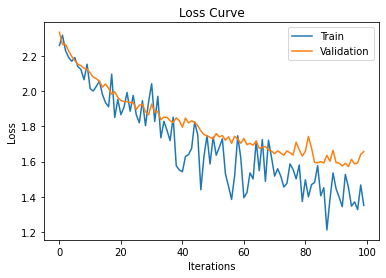

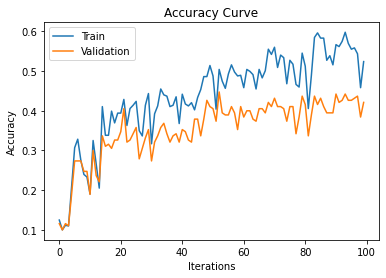

Final Training Accuracy: 0.5238095238095238
Final Validation Accuracy: 0.42105263157894735


In [ ]:
base = Baseline()
iters, train_loss, val_loss, train_acc, val_acc = train_model(base, T_loader, V_loader, learning_rate=5e-4, epochs=100)

# plotting
plt.title("Loss Curve")
plt.plot(iters, train_loss, label="Train")
plt.plot(iters, val_loss, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

plt.title("Accuracy Curve")
plt.plot(iters, train_acc, label="Train")
plt.plot(iters, val_acc, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

print("Final Training Accuracy: {}".format(train_acc[-1]))
print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [ ]:
test_acc = get_accuracy(base, E_loader)
print("The baseline ANN model accuracy with the test dataset is", test_acc)

The baseline ANN model accuracy with the test dataset is 0.355


In [ ]:
batch = 32
num_workers = 1

E_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch,
                                           num_workers=num_workers, shuffle=True)
V_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch,
                                           num_workers=num_workers, shuffle=True)
T_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch,
                                           num_workers=num_workers, shuffle=True)

Epoch 1: Train loss: 2.276195526123047, Train accuracy: 0.10673234811165845 | Validation loss: 2.3029383023579917, Validation accuracy: 0.11052631578947368
Epoch 2: Train loss: 2.2785580158233643, Train accuracy: 0.10509031198686371 | Validation loss: 2.265472173690796, Validation accuracy: 0.11052631578947368
Epoch 3: Train loss: 2.214123010635376, Train accuracy: 0.180623973727422 | Validation loss: 2.2568830649058023, Validation accuracy: 0.16842105263157894
Epoch 4: Train loss: 2.2446649074554443, Train accuracy: 0.19540229885057472 | Validation loss: 2.2421818574269614, Validation accuracy: 0.18421052631578946
Epoch 5: Train loss: 2.17183780670166, Train accuracy: 0.14614121510673234 | Validation loss: 2.203935384750366, Validation accuracy: 0.13157894736842105
Epoch 6: Train loss: 2.223618507385254, Train accuracy: 0.26929392446633826 | Validation loss: 2.174712657928467, Validation accuracy: 0.2578947368421053
Epoch 7: Train loss: 2.1744937896728516, Train accuracy: 0.3366174055

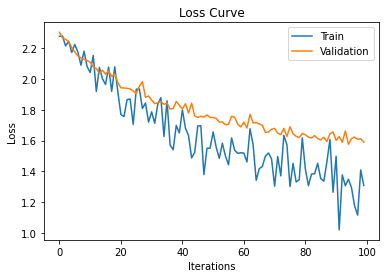

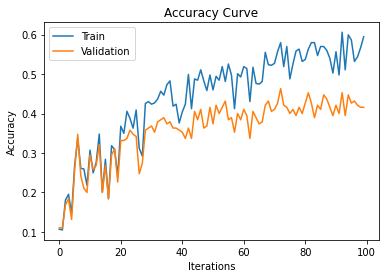

Final Training Accuracy: 0.5944170771756979
Final Validation Accuracy: 0.41578947368421054


In [ ]:
base = Baseline()
iters, train_loss, val_loss, train_acc, val_acc = train_model(base, T_loader, V_loader, learning_rate=5e-4, epochs=100)

# plotting
plt.title("Loss Curve")
plt.plot(iters, train_loss, label="Train")
plt.plot(iters, val_loss, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

plt.title("Accuracy Curve")
plt.plot(iters, train_acc, label="Train")
plt.plot(iters, val_acc, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

print("Final Training Accuracy: {}".format(train_acc[-1]))
print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [ ]:
test_acc = get_accuracy(base, E_loader)
print("The baseline ANN model accuracy with the test dataset is", test_acc)

The baseline ANN model accuracy with the test dataset is 0.45


The following is ANN tests with Spotify data

In [ ]:
drive_path='/content/drive/MyDrive/Project/NewData_spotify/Split_Set'
train_set = drive_path+'/'+'train'
val_set = drive_path+'/'+'valid'
test_set = drive_path+'/'+'test'

#Defining transforms
transform = transforms.Compose([transforms.Resize((418,627)),
                                transforms.ToTensor()])
train_dataset = torchvision.datasets.ImageFolder(train_set +'/', transform=transform)
valid_dataset = torchvision.datasets.ImageFolder(val_set+'/', transform=transform)
test_dataset = torchvision.datasets.ImageFolder(test_set+'/', transform=transform)

print("train set size: ", len(train_dataset))
print("validation set size: ", len(valid_dataset))
print("test set size: ", len(test_dataset))

batch = 32
num_workers = 1

E_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch,
                                           num_workers=num_workers, shuffle=True)
V_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch,
                                           num_workers=num_workers, shuffle=True)
T_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch,
                                           num_workers=num_workers, shuffle=True)


train set size:  3020
validation set size:  980
test set size:  1000


Epoch 1: Train loss: 2.2183802127838135, Train accuracy: 0.2599337748344371 | Validation loss: 2.0289758366923176, Validation accuracy: 0.2530612244897959
Epoch 2: Train loss: 1.9458693265914917, Train accuracy: 0.2870860927152318 | Validation loss: 1.8835886563024213, Validation accuracy: 0.26632653061224487
Epoch 3: Train loss: 1.5840696096420288, Train accuracy: 0.2913907284768212 | Validation loss: 1.8766825276036416, Validation accuracy: 0.29081632653061223
Epoch 4: Train loss: 1.5959464311599731, Train accuracy: 0.3271523178807947 | Validation loss: 1.7731836726588588, Validation accuracy: 0.3306122448979592
Epoch 5: Train loss: 1.9273113012313843, Train accuracy: 0.29172185430463576 | Validation loss: 1.8729014319758261, Validation accuracy: 0.2969387755102041
Epoch 6: Train loss: 1.33462393283844, Train accuracy: 0.3314569536423841 | Validation loss: 1.7765718736956198, Validation accuracy: 0.3153061224489796
Epoch 7: Train loss: 1.3179959058761597, Train accuracy: 0.3718543046

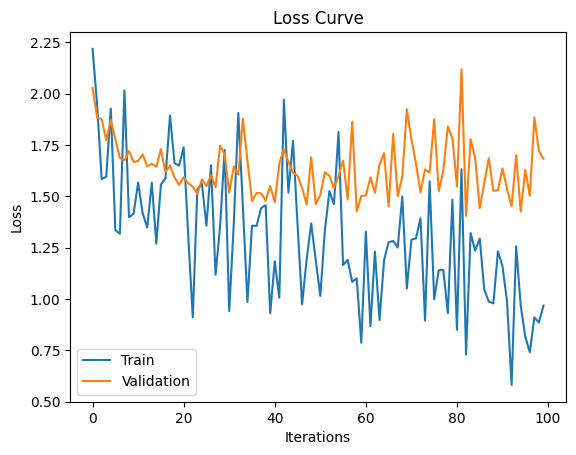

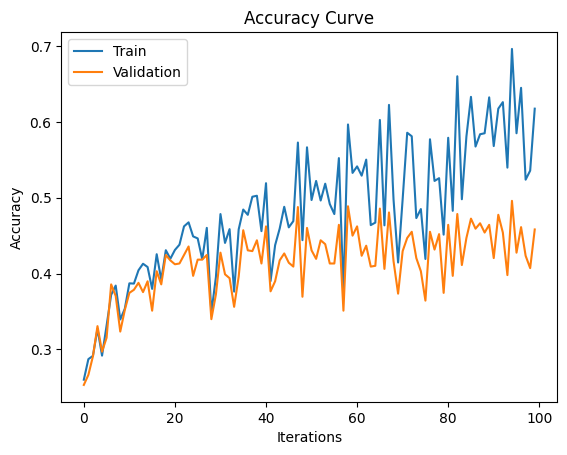

Final Training Accuracy: 0.6175496688741722
Final Validation Accuracy: 0.45816326530612245
The baseline ANN model accuracy with the test dataset is 0.44


In [ ]:
base = Baseline()
iters, train_loss, val_loss, train_acc, val_acc = train_model(base, T_loader, V_loader, learning_rate=5e-4, epochs=100)

# plotting
plt.title("Loss Curve")
plt.plot(iters, train_loss, label="Train")
plt.plot(iters, val_loss, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

plt.title("Accuracy Curve")
plt.plot(iters, train_acc, label="Train")
plt.plot(iters, val_acc, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

print("Final Training Accuracy: {}".format(train_acc[-1]))
print("Final Validation Accuracy: {}".format(val_acc[-1]))

test_acc = get_accuracy(base, E_loader)
print("The baseline ANN model accuracy with the test dataset is", test_acc)

In [ ]:
testmod = Baseline()
iters, train_loss, val_loss, train_acc, val_acc = train_model(testmod, T_loader, V_loader, learning_rate=5e-4, epochs=1)

In [ ]:
# define test dataset and set up the loader for test dataset

genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
accuracy_per_class = get_genre_accuracy(testmod, E_loader)

print(accuracy_per_class)

plt.figure(figsize=(10,6))
plt.bar(genres, accuracy_per_class)
plt.xlabel("Music Genre")
plt.ylabel("Accuracy")
plt.title("ResNet Accuracy Across Different Genres")
plt.show()

The following is tests on the data collected from YouTube and Spotify

In [ ]:
drive_path='/content/drive/MyDrive/Project/NewData_spotify/Split_Set'
newYT_path = '/content/drive/MyDrive/Project/NewData_YT/Spectrograms'
newSpot_path = '/content/drive/MyDrive/Project/final_spectrograms'
train_set = drive_path+'/'+'train'
val_set = drive_path+'/'+'valid'
testYT_set = newYT_path
testSP_set = newSpot_path

#Defining transforms
transform = transforms.Compose([transforms.Resize((418,627)),
                                transforms.ToTensor()])
train_dataset = torchvision.datasets.ImageFolder(train_set +'/', transform=transform)
valid_dataset = torchvision.datasets.ImageFolder(val_set+'/', transform=transform)
testYT_dataset = torchvision.datasets.ImageFolder(testYT_set+'/', transform=transform)
testSP_dataset = torchvision.datasets.ImageFolder(testSP_set+'/', transform=transform)

print("train set size: ", len(train_dataset))
print("validation set size: ", len(valid_dataset))
print("YouTube test set size: ", len(testYT_dataset))
print("Spotify test set size: ", len(testSP_dataset))

batch = 32
num_workers = 1

EYT_loader = torch.utils.data.DataLoader(testYT_dataset, batch_size=batch,
                                           num_workers=num_workers, shuffle=True)
ESP_loader = torch.utils.data.DataLoader(testSP_dataset, batch_size=batch,
                                           num_workers=num_workers, shuffle=True)
V_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch,
                                           num_workers=num_workers, shuffle=True)
T_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch,
                                           num_workers=num_workers, shuffle=True)

train set size:  3020
validation set size:  980
YouTube test set size:  20
Spotify test set size:  20


In [ ]:
testmod = Baseline()
iters, train_loss, val_loss, train_acc, val_acc = train_model(testmod, T_loader, V_loader, learning_rate=5e-4, epochs=100)

Epoch 1: Train loss: 2.12194561958313, Train accuracy: 0.2731788079470199 | Validation loss: 1.9672907590866089, Validation accuracy: 0.27653061224489794
Epoch 2: Train loss: 1.9076193571090698, Train accuracy: 0.2850993377483444 | Validation loss: 1.903565687517966, Validation accuracy: 0.27448979591836736
Epoch 3: Train loss: 1.8290842771530151, Train accuracy: 0.28741721854304636 | Validation loss: 1.8342908659288961, Validation accuracy: 0.2938775510204082
Epoch 4: Train loss: 1.5046466588974, Train accuracy: 0.32384105960264903 | Validation loss: 1.799484452893657, Validation accuracy: 0.3346938775510204
Epoch 5: Train loss: 1.929954171180725, Train accuracy: 0.34139072847682117 | Validation loss: 1.81777576861843, Validation accuracy: 0.32755102040816325
Epoch 6: Train loss: 1.9919742345809937, Train accuracy: 0.36026490066225164 | Validation loss: 1.7318373034077306, Validation accuracy: 0.3551020408163265
Epoch 7: Train loss: 1.74657142162323, Train accuracy: 0.3665562913907285

In [ ]:
test_accYT = get_accuracy(testmod, EYT_loader)
print("The baseline ANN model accuracy with the Youtube dataset is", test_accYT)

The baseline ANN model accuracy with the Youtube dataset is 0.1


In [ ]:
test_accSP = get_accuracy(testmod, ESP_loader)
print("The baseline ANN model accuracy with the Spotify test dataset is", test_accSP)

The baseline ANN model accuracy with the Spotify test dataset is 0.3


In [ ]:
use_cuda = True
def get_top3_accuracy(model, data_loader, n):
    correct = 0
    total = 0
    count = 0
    for images, labels in iter(data_loader):
        for index, image in enumerate(images):
            #count += 1
            #print(count)
            #images, labels = images.cuda(), labels.cuda()
            output = model(images)
            probs = nn.Softmax(dim=1)
            output = probs(output)

            for i in range(len(output)):
                top3 = torch.topk(output[i].flatten(), n).indices
                lab = labels[i].data
                #print(top3, lab, (lab in top3))
                total += 1
                if lab in top3:
                    correct += 1


    acc = correct/total


    return acc

In [ ]:
use_cuda = True
CUDA_VISIBLE_DEVICES=1

In [ ]:
# Top 2
test_accYT2 = get_top3_accuracy(testmod, EYT_loader, 2)
print("The baseline ANN model accuracy (top 2 predictions) with the Youtube test dataset is", test_accYT2)

test_accSP2 = get_top3_accuracy(testmod, ESP_loader, 2)
print("The baseline ANN model accuracy (top 2 predictions) with the Spotify test dataset is", test_accSP2)

1
tensor([8, 3]) tensor(2) False
tensor([8, 3]) tensor(2) False
tensor([3, 8]) tensor(8) True
tensor([3, 2]) tensor(9) False
tensor([8, 3]) tensor(6) False
tensor([8, 3]) tensor(3) True
tensor([3, 8]) tensor(1) False
tensor([3, 8]) tensor(7) False
tensor([8, 1]) tensor(1) True
tensor([5, 3]) tensor(0) False
tensor([8, 3]) tensor(4) False
tensor([2, 8]) tensor(9) False
tensor([8, 3]) tensor(6) False
tensor([3, 8]) tensor(7) False
tensor([8, 3]) tensor(4) False
tensor([3, 8]) tensor(3) True
tensor([1, 0]) tensor(0) True
tensor([8, 3]) tensor(8) True
tensor([8, 3]) tensor(5) False
tensor([8, 3]) tensor(5) False
2
tensor([8, 3]) tensor(2) False
tensor([8, 3]) tensor(2) False
tensor([3, 8]) tensor(8) True
tensor([3, 2]) tensor(9) False
tensor([8, 3]) tensor(6) False
tensor([8, 3]) tensor(3) True
tensor([3, 8]) tensor(1) False
tensor([3, 8]) tensor(7) False
tensor([8, 1]) tensor(1) True
tensor([5, 3]) tensor(0) False
tensor([8, 3]) tensor(4) False
tensor([2, 8]) tensor(9) False
tensor([8, 3]

In [ ]:
# Top 3
test_accYT3 = get_top3_accuracy(testmod, EYT_loader, 3)
print("The baseline ANN model accuracy (top 3 predictions) with the Youtube test dataset is", test_accYT3)

test_accSP3 = get_top3_accuracy(testmod, ESP_loader, 3)
print("The baseline ANN model accuracy (top 3 predictions) with the Spotify test dataset is", test_accSP3)

The baseline ANN model accuracy (top 3 predictions) with the Youtube test dataset is 0.45
The baseline ANN model accuracy (top 3 predictions) with the Spotify test dataset is 0.7


In [ ]:
# Top 1
test_accYT1 = get_top3_accuracy(testmod, EYT_loader, 1)
print("The baseline ANN model accuracy (top 1 prediction) with the Youtube test dataset is", test_accYT1)

test_accSP1 = get_top3_accuracy(testmod, ESP_loader, 1)
print("The baseline ANN model accuracy (top 1 prediction) with the Spotify test dataset is", test_accSP1)

The baseline ANN model accuracy (top 1 prediction) with the Youtube test dataset is 0.1
The baseline ANN model accuracy (top 1 prediction) with the Spotify test dataset is 0.3


In [ ]:
model_save_name = 'baselineANN.pt'
path = F"/content/drive/MyDrive/Project/{model_save_name}"
torch.save(testmod.state_dict(), path)

#**SCRAP SECTION**

In [ ]:
y, sr = librosa.load('/content/Data/genres_original/jazz/jazz.00054.wav', sr =32000)
y, sr = librosa.load('/content/Data/genres_original/jazz/jazz.00054.wav', sr =32000)
librosa.display.waveshow(y, max_points=11025, x_axis = 's')
Audio('/content/Data/genres_original/jazz/jazz.00054.wav')

In [ ]:
n_fft = 1024
hop_length = 320
window_type = 'hann'
spectrogram_librosa = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=n_fft, window=window_type)) **2

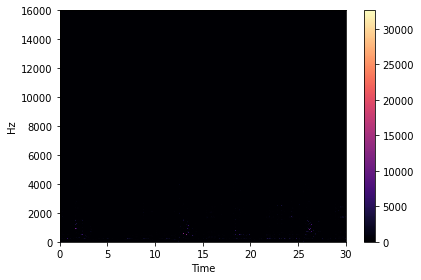

In [ ]:
librosa.display.specshow(spectrogram_librosa, sr=sr, x_axis='time', y_axis='linear', hop_length=hop_length)
plt.colorbar()
plt.tight_layout()
plt.show()

The shape of mel spectrogram is:  (64, 3002)


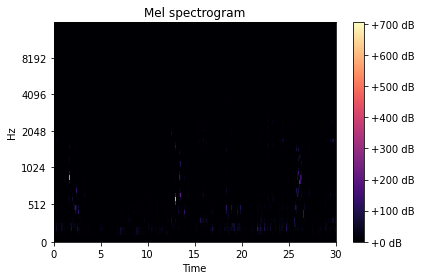

The shape of Log Mel spectrogram is:  (64, 3002)


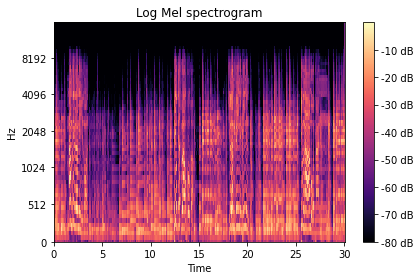

<Figure size 432x288 with 0 Axes>

In [ ]:
mel_bins = 64 # Number of mel bands
fmin = 0
fmax= None
Mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft,
                                                 hop_length=hop_length,
                                                 win_length=n_fft,
                                                 window=window_type,
                                                 n_mels = mel_bins,
                                                 power=2.0)
print("The shape of mel spectrogram is: ", Mel_spectrogram.shape)

librosa.display.specshow(Mel_spectrogram, sr=sr, x_axis='time', y_axis='mel',hop_length=hop_length)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()
plt.show()

mel_spectrogram_db = librosa.power_to_db(Mel_spectrogram, ref=np.max)
print("The shape of Log Mel spectrogram is: ", mel_spectrogram_db.shape)
librosa.display.specshow(mel_spectrogram_db, sr=sr, x_axis='time', y_axis='mel',hop_length=hop_length)
plt.colorbar(format='%+2.0f dB')
plt.title('Log Mel spectrogram')
plt.tight_layout()
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('./'+str(1)+'.png', dpi= 128, bbox_inches='tight')


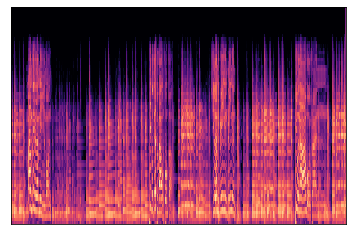

<Figure size 432x288 with 0 Axes>

In [ ]:
##### TO SAVE THE PLOT #####
fig = plt.Figure(figsize=(8,8), dpi=128, frameon=False)
canvas = FigureCanvas(fig)
ax = fig.add_subplot(111)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_frame_on(False)
librosa.display.specshow(mel_spectrogram_db)
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('./'+str(1)+'.png', dpi= 128, bbox_inches='tight')


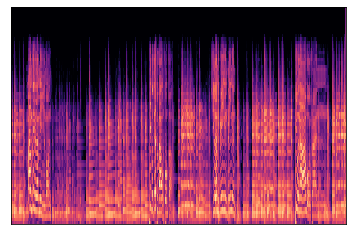

<Figure size 432x288 with 0 Axes>

In [ ]:
convert_to_spectrogram('/content/Data/genres_original/blues/blues.00006.wav')

In [ ]:
for i in os.listdir('/content'):
  if '.zip' in i:
    !unzip $i

Archive:  NewData.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of NewData.zip or
        NewData.zip.zip, and cannot find NewData.zip.ZIP, period.


In [ ]:
for i in os.listdir('/content/drive/MyDrive/Project/NewData_YT'):
  if i == '.DS_Store':
    continue
  for j in os.listdir(os.path.join('/content/drive/MyDrive/Project/NewData_YT', i)):
    if '.wav' in j:
      if not os.path.exists(os.path.join('/content/drive/MyDrive/Project/NewData_YT/Spectrograms', i)):
        os.mkdir(os.path.join('/content/drive/MyDrive/Project/NewData_YT/Spectrograms', i))
      convert_to_spectrogram(os.path.join('/content/drive/MyDrive/Project/NewData_YT', i, j),
                                          os.path.join('/content/drive/MyDrive/Project/NewData_YT/Spectrograms', i, j))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
for i in os.listdir('/content/drive/MyDrive/Project/wav_final'):
  if i == '.DS_Store': continue
  for j in os.listdir(os.path.join('/content/drive/MyDrive/Project/wav_final', i)):
    if not os.path.exists(os.path.join('/content/drive/MyDrive/Project/final_spectrograms', i)):
      os.mkdir(os.path.join('/content/drive/MyDrive/Project/final_spectrograms', i))
    convert_to_spectrogram(os.path.join('/content/drive/MyDrive/Project/wav_final', i, j), os.path.join('/content/drive/MyDrive/Project/final_spectrograms', i, j))

Output hidden; open in https://colab.research.google.com to view.